In [7]:
import jax
import jax.numpy as jnp
import optax
from flax import nnx
from model import DAGMM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors
from numpy import random

from utils import calc_prf, calc_sample_energies
from dataloader import get_dataloader
from eval import eval

In [8]:
jax.config.update("jax_debug_nans", True)
key = jax.random.PRNGKey(random.randint(0, 2**32))
batch_size = 1024
key, dataloader_key = jax.random.split(key, 2)

model = DAGMM(n_features=118, rngs=nnx.Rngs(key))
dataloader_train = get_dataloader(
    dataloader_key, batch_size=batch_size, mode="train", overwrite=True
)
dataloader_test = get_dataloader(None, batch_size=batch_size, mode="test")

learning_rate = 0.0001
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))
metrics = nnx.MultiMetric(loss=nnx.metrics.Average("loss"))

In [9]:
def _objective_fn(model: DAGMM, inputs):
    gamma, x_hat, z = model(inputs)
    
    phi, mu, covariances = model.calc_mixture_stats(inputs, gamma, z)
    mse = jnp.mean(jnp.linalg.norm(inputs - x_hat, axis=-1)**2)

    energy = jnp.mean(calc_sample_energies(phi, mu, covariances, z))
    reg_1 = model.lambda_1 * energy
    reg_2 = model.lambda_2 * (jnp.sum(jnp.diagonal(covariances, axis1=1, axis2=2) ** -1))
    
    return mse + reg_1 + reg_2, (phi, mu, covariances)

@nnx.jit
def _train_step(model: DAGMM, optimizer: nnx.Optimizer, 
               metrics: nnx.MultiMetric, inputs: jnp.ndarray):
    """Train for a single step."""
    grad_fn = nnx.value_and_grad(_objective_fn, has_aux=True)
    (loss, stats), grads = grad_fn(model, inputs)
    metrics.update(loss=loss)
    optimizer.update(grads)
    return stats
    
def _train_epoch(model: DAGMM, optimizer: nnx.Optimizer,
                metrics: nnx.MultiMetric, dataloader):
    """Train for a single epoch."""
    phis = []
    # mus = []
    # covs = []
    
    for step, (inputs, _) in enumerate(dataloader):
        inputs = jax.tree.map(lambda x: jnp.array(x), inputs)
        phi, mu, cov = _train_step(model, optimizer, metrics, inputs)
        phis.append(phi)
        # mus.append(mu)
        # covs.append(cov)
        
    phis = jnp.stack(phis, axis=0)
    return phis

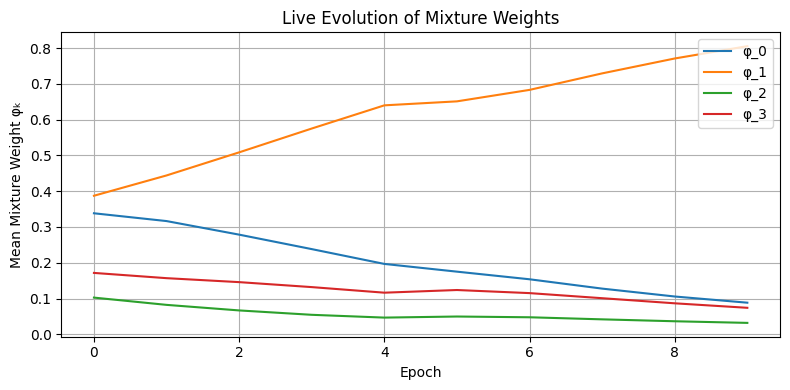

In [10]:
from IPython.display import clear_output

phi_means = []

for _ in range(10):
    phis = _train_epoch(model, optimizer, metrics, dataloader_train)
    phi_means.append(jnp.mean(phis, axis=0))

    clear_output(wait=True)
    phi_array = jnp.stack(phi_means, axis=0)  # shape (epoch+1, 4)

    plt.figure(figsize=(8, 4))
    for k in range(phi_array.shape[1]):
        plt.plot(phi_array[:, k], label=f'φ_{k}')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Mixture Weight φₖ')
    plt.title('Live Evolution of Mixture Weights')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)
    


In [11]:
z, energy, labels = eval(model, dataloader_train, dataloader_test)
precision, recall, f1 = calc_prf(energy, labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Evaluating test data:   0%|          | 0/289 [00:00<?, ?it/s]/home/whjiang/source/school/jax-DAGMM/venv/lib64/python3.9/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
Evaluating test data: 100%|██████████| 289/289 [04:53<00:00,  1.01s/it]


Threshold: 3.1213958263397217
Precision: 0.8550275795759323
Recall: 0.8684491868665063
F1: 0.8616861227133408
